## 4.3 앙상블 학습 개요

대표적인 앙상블 알고리즘

: 랜덤포레스트, Gradient Boosting, XGBoost, LightGBM

학습 유형
* voting
* bagging
* boosting

단일 모델의 약점을 다수의 모델들을 결합하여 보완
성능이 떨어지더라도 서로다른 유형의 모델을 섞는 것이 오히려 전체 성능에 도움이 될 수 있음
랜덤포레스트 및 뛰어난 알고리즘들은 모두 결정 트리 알고리즘 기반 알고리즘으로 적용함
결정트리의 단점인 과적합을 수십~수천개의 많은 분류기를 결합해 보완하고 장점인 직관적인 분류 기준은 강화됨

### Voting Classifier

_하드 보팅(Hard Voting) 과 소프트 보팅(Soft Voting)_


하드 보팅의 경우 각 분류기가 예측한 결과를 다수결로 최종 class로 결정하는 방식이고, 소프트 보팅의 경우 각 분류기가 예측한 확률을 평균하여 결정하는 방식

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [2]:
# 개별 모델은 로지스틱 회귀와 KNN 임. 
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('KNN',knn_clf)] , voting='soft' )

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2 , random_state= 156)

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


C:\Users\j7a3e\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## 4.4 Random Forest

장점 :
앙상블 알고리즘 중 비교적 빠른 수행 속도
다양한 영역에서 높은 예측 성능
결정 트리를 기반으로 한 알고리즘 -> 쉽고 직관적

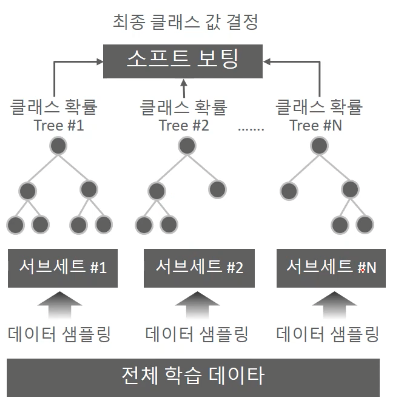

In [3]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [7]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('C:/Users/j7a3e/대학/CUAI/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('C:/Users/j7a3e/대학/CUAI/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('C:/Users/j7a3e/대학/CUAI/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('C:/Users/j7a3e/대학/CUAI/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('C:/Users/j7a3e/대학/CUAI/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


In [9]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [10]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, \
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9165


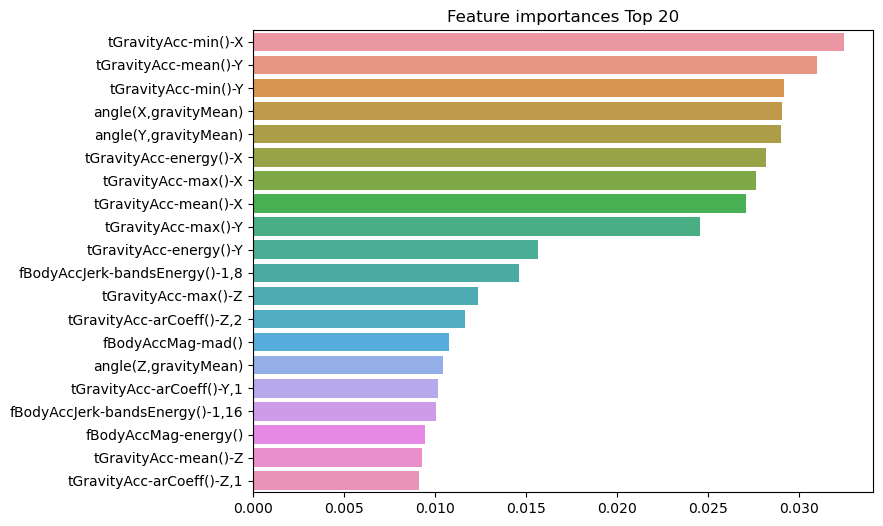

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('rf_feature_importances_top20.tif', format='tif', dpi=300, bbox_inches='tight')

## 4.5 GBM(Gradient Boosting Machine)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))


In [ ]:
### 아래는 책에서 설명드리지는 않지만 GridSearchCV로 GBM의 하이퍼 파라미터 튜닝을 수행하는 예제 입니다. 
### 사이킷런이 1.X로 업그레이드 되며서 GBM의 학습 속도가 현저하게 저하되는 문제가 오히려 발생합니다. 
### 아래는 수행 시간이 오래 걸리므로 참고용으로만 사용하시면 좋을 것 같습니다. 

from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

In [ ]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))